In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import sys
import os
from pathlib import Path

sns.set(style="ticks")

"""Initialize paths for finding/saving files"""
prefix = os.getcwd()
source = Path(prefix + '/logs/')
dest = Path(prefix + '/figs/')
files = os.listdir(source)

for i in range(len(files)):
    files[i] = os.path.join(source, files[i])
    
print('plotting files: ' + str(files))

plotting files: ['/home/brant/development/benchmarking-models/logs/mobilenet-zed.log', '/home/brant/development/benchmarking-models/logs/mobilenet-x86.log']


In [11]:
def getAllData(files):
    """Given a list of files, get all data for each file"""
    
    avgTimes = re.compile(r'Timings \(microseconds\): .*? avg=(?P<avg>\d+)')
    numThreads = re.compile(r'Num threads: \[(?P<num>\d+?)\]')
    model = re.compile(r'Model name:\s{12}(?P<model>.+)')
    
    summaryGroup = re.compile(r"""=+\s+[Node\stype].+\n
        \s+(?P<conv2d>CONV_2D)\s+\d+\s+(?P<conv_avg>\d+\.\d+).+\n
        \s+(?P<depthwise>DEPTHWISE_CONV_2D)\s+\d+\s+(?P<depth_avg>\d+\.\d+).+\n
        \s+(?P<avg_pool>AVERAGE_POOL_2D)\s+\d+\s+(?P<pool_avg>\d+\.\d+).+\n
        \s+(?P<softmax>SOFTMAX)\s+\d+\s+(?P<softmax_avg>\d+\.\d+).+\n
        \s+(?P<reshape>RESHAPE)\s+\d+\s+(?P<reshape_avg>\d+\.\d+)\s+""", re.X)
    
    individualNodes = re.compile(r"""\s+
        (?P<node_name>\S+)\s+ 
        \d+\.\d+ \s+
        \d+\.\d+ \s+
        (?P<node_avg>\d+\.\d+)""", re.X)
    
    runOrder = re.compile(r"""=+ Run Order =+\n""")
    compTime = re.compile(r"""=+ Top by Computation Time =+\n""")
    
    """Create lists to store data for the dataframes"""
    threads = []
    avgTotals = []
    models = []
    
    threadsAndModel = []
    nodeTypes = []
    nodeTypeAvgs = []
    
    nodes = []
    runtimes = []
    individualThreads = []
    nodeNums = []
    
    for file in files:
        with open(file) as f:
            lines = f.read()
            
            """find all the data"""
            currThreads = re.findall(numThreads, lines)
            summary = re.findall(summaryGroup, lines)
            totals = re.findall(avgTimes, lines)
            modelName = re.search(model, lines).group('model')
            
            runLocations = re.finditer(runOrder, lines)
            compTimeLocations = re.finditer(compTime, lines)
            
            avgTotals.extend(totals)
            threads.extend(currThreads)
            mName = [modelName] * len(currThreads)
            models.extend(mName)
           
            """cast the avg times and threads as ints, since re returns them as strings 
            (for the avg times by # threads)"""
            for i in range(len(avgTotals)):
                avgTotals[i] = int(avgTotals[i])
                threads[i] = int(threads[i])
         
            """separate nodeTypes and avg times into 2 different lists to go into the data frame
            (for avg times by node type)"""
            groupCount=0
            for group in summary:
                for i in range(len(group)):
                    if i % 2 == 0:
                        nodeTypes.append(group[i])
                        threadsAndModel.append(str(currThreads[groupCount]) + '-' + modelName)
                    else:
                        nodeTypeAvgs.append(float(group[i]))
                groupCount+=1
            
            """gather data for each inidividual node in each group of nodes by type
            (for avg time by node type)"""
            runCount=0
            for run in runLocations:
                end = next(compTimeLocations).start()
                runData = re.findall(individualNodes, lines[run.start():end])
                
                nodeNum = 0
                for node in runData:
                    nodeNums.append(nodeNum)
                    nodes.append(node[0])
                    runtimes.append(float(node[1]))
                    individualThreads.append(str(currThreads[runCount]) + '-' + modelName)
                    
                    nodeNum+=1
                runCount+=1
                
    threadData = {"# threads" : threads, "avg runtime (ms)" : avgTotals, "model" : models}
    nodeData = {"avg ms" : nodeTypeAvgs, "node type" : nodeTypes, "model" : threadsAndModel}
    individualData = {"node" : nodes, "avg ms" : runtimes, "model" : individualThreads, "id" : nodeNums }
    
    return (pd.DataFrame(threadData), pd.DataFrame(nodeData), pd.DataFrame(individualData))


In [12]:
def plotByThreads(datasets, save):
    """produce plots for average times by # of threads, given list of pandas dataframes produced by getAllData()"""
    avgByThreads = sns.catplot("# threads", col="model", y="avg runtime (ms)", kind="bar", data=datasets[0])
    if (save == True):
        plt.savefig(os.path.join(dest,"avg_ms_threads.jpg"))
    
def plotByType(datasets, save):
    """produce plots for average times by type of node, given list of pandas dataframes produced by getAllData()"""
    avgByNodeType= sns.catplot("node type", y="avg ms", kind="bar", col = "model", data=datasets[1], 
                               col_wrap=2, ci=None, aspect = 1.9)
    if (save == True):
        plt.savefig(os.path.join(dest,"avg_ms_node_type.jpg"))

def plotByNode(datasets, save):
    """produce plots for individual node avg times, given list of pandas dataframes produced by getAllData()"""
    avgByNode = sns.catplot(x="id", y="avg ms", kind="bar", col = "model", col_wrap = 2, data=datasets[2], 
                            hue = "node", ci=None, aspect = 1.9)
    if (save == True):
        plt.savefig(os.path.join(dest,"avg_ms_each_node.jpg"))

In [13]:
def plotAll(files, save) :
    """Creates graphs for all of the data gathered"""
    datasets = getAllData(files)
    
    plotByThreads(datasets, save)
    plotByType(datasets, save)
    plotByNode(datasets, save)
    

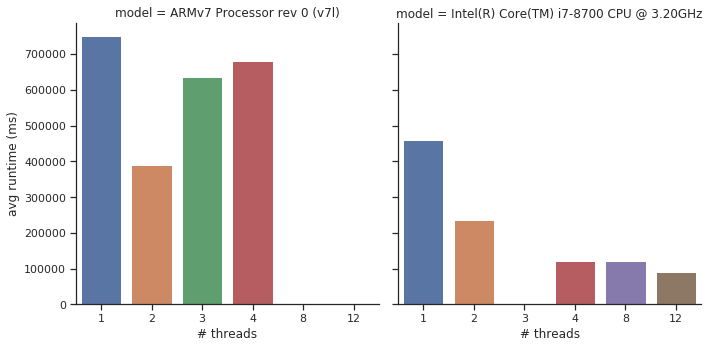

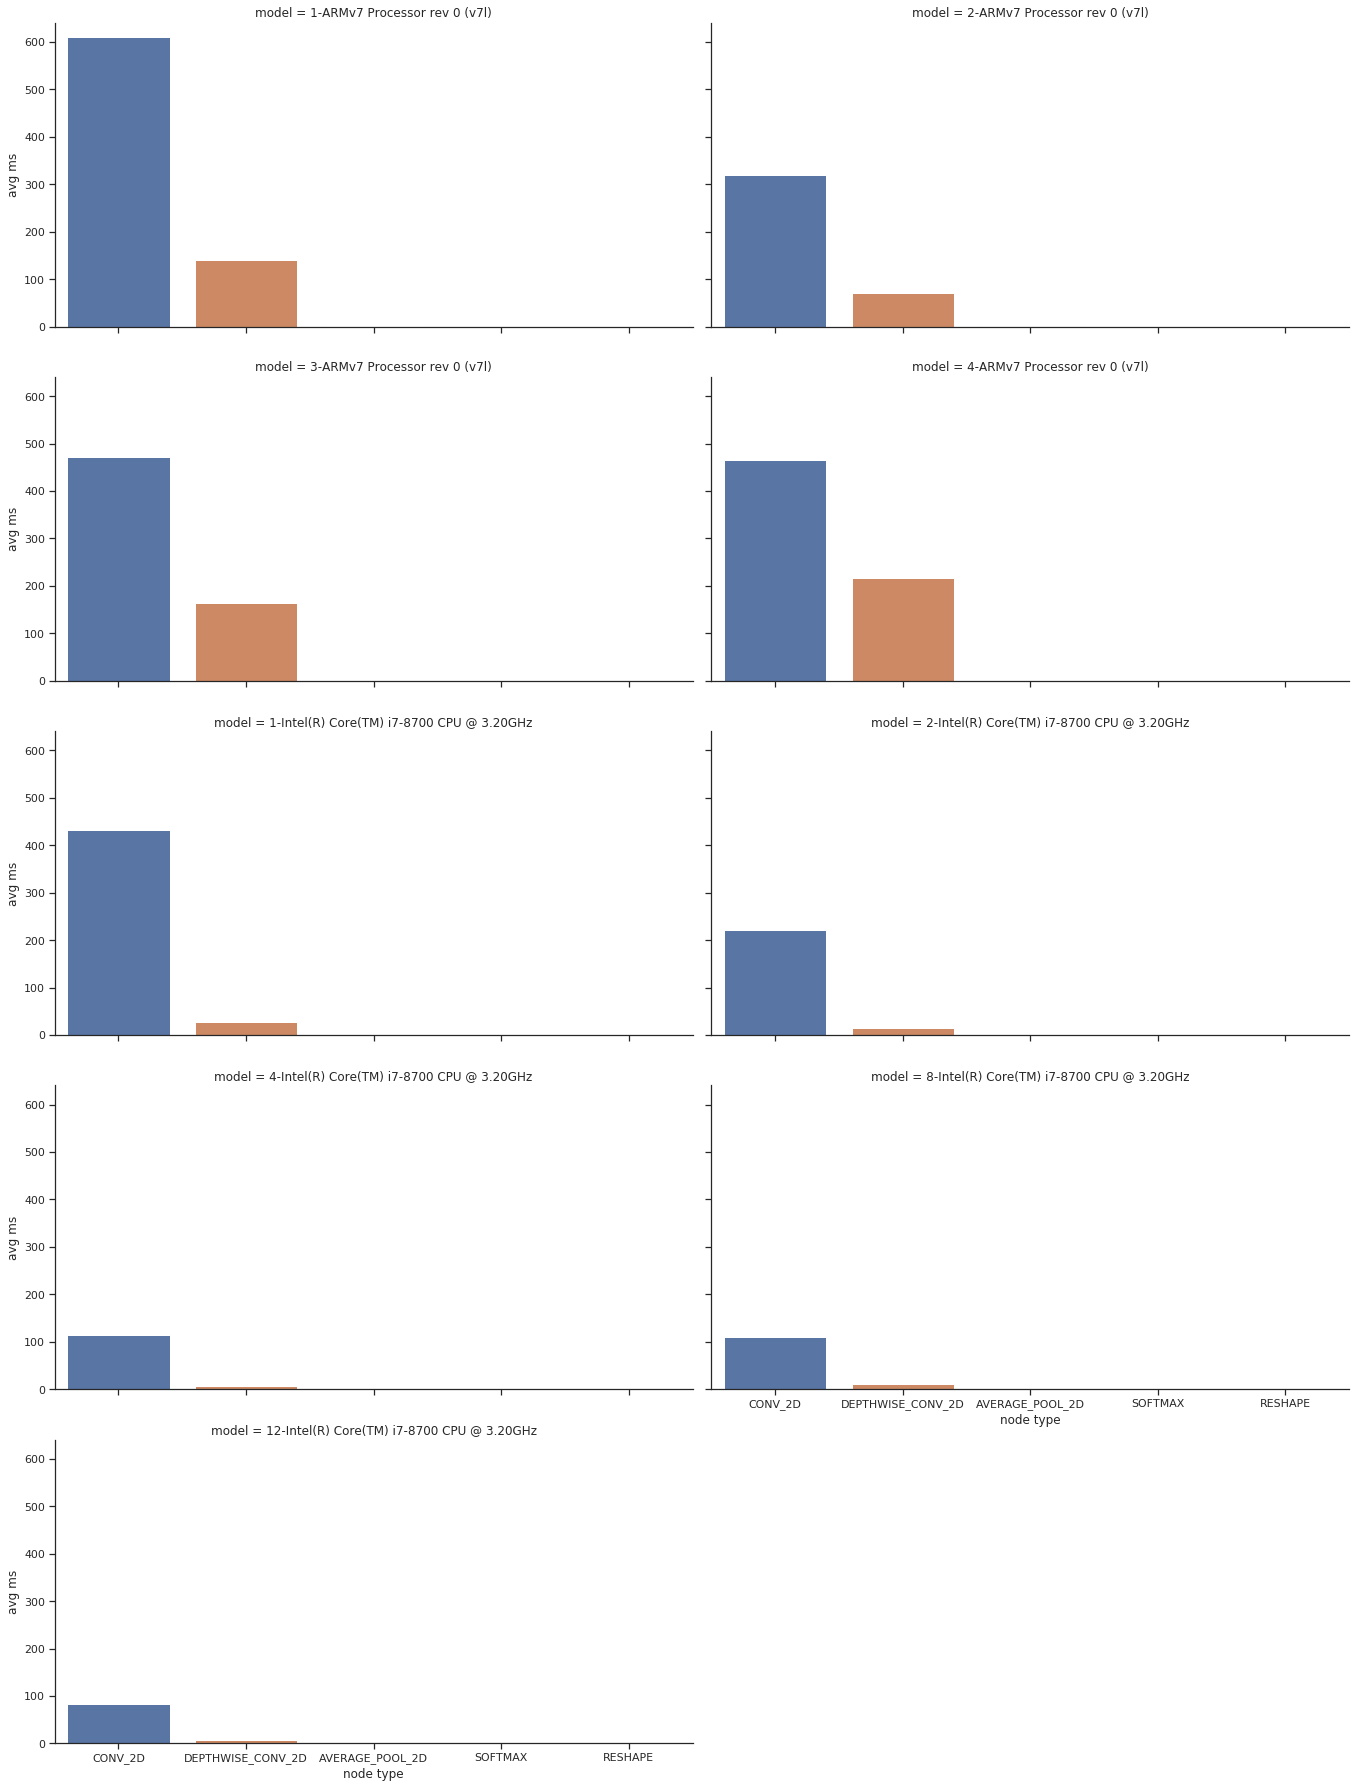

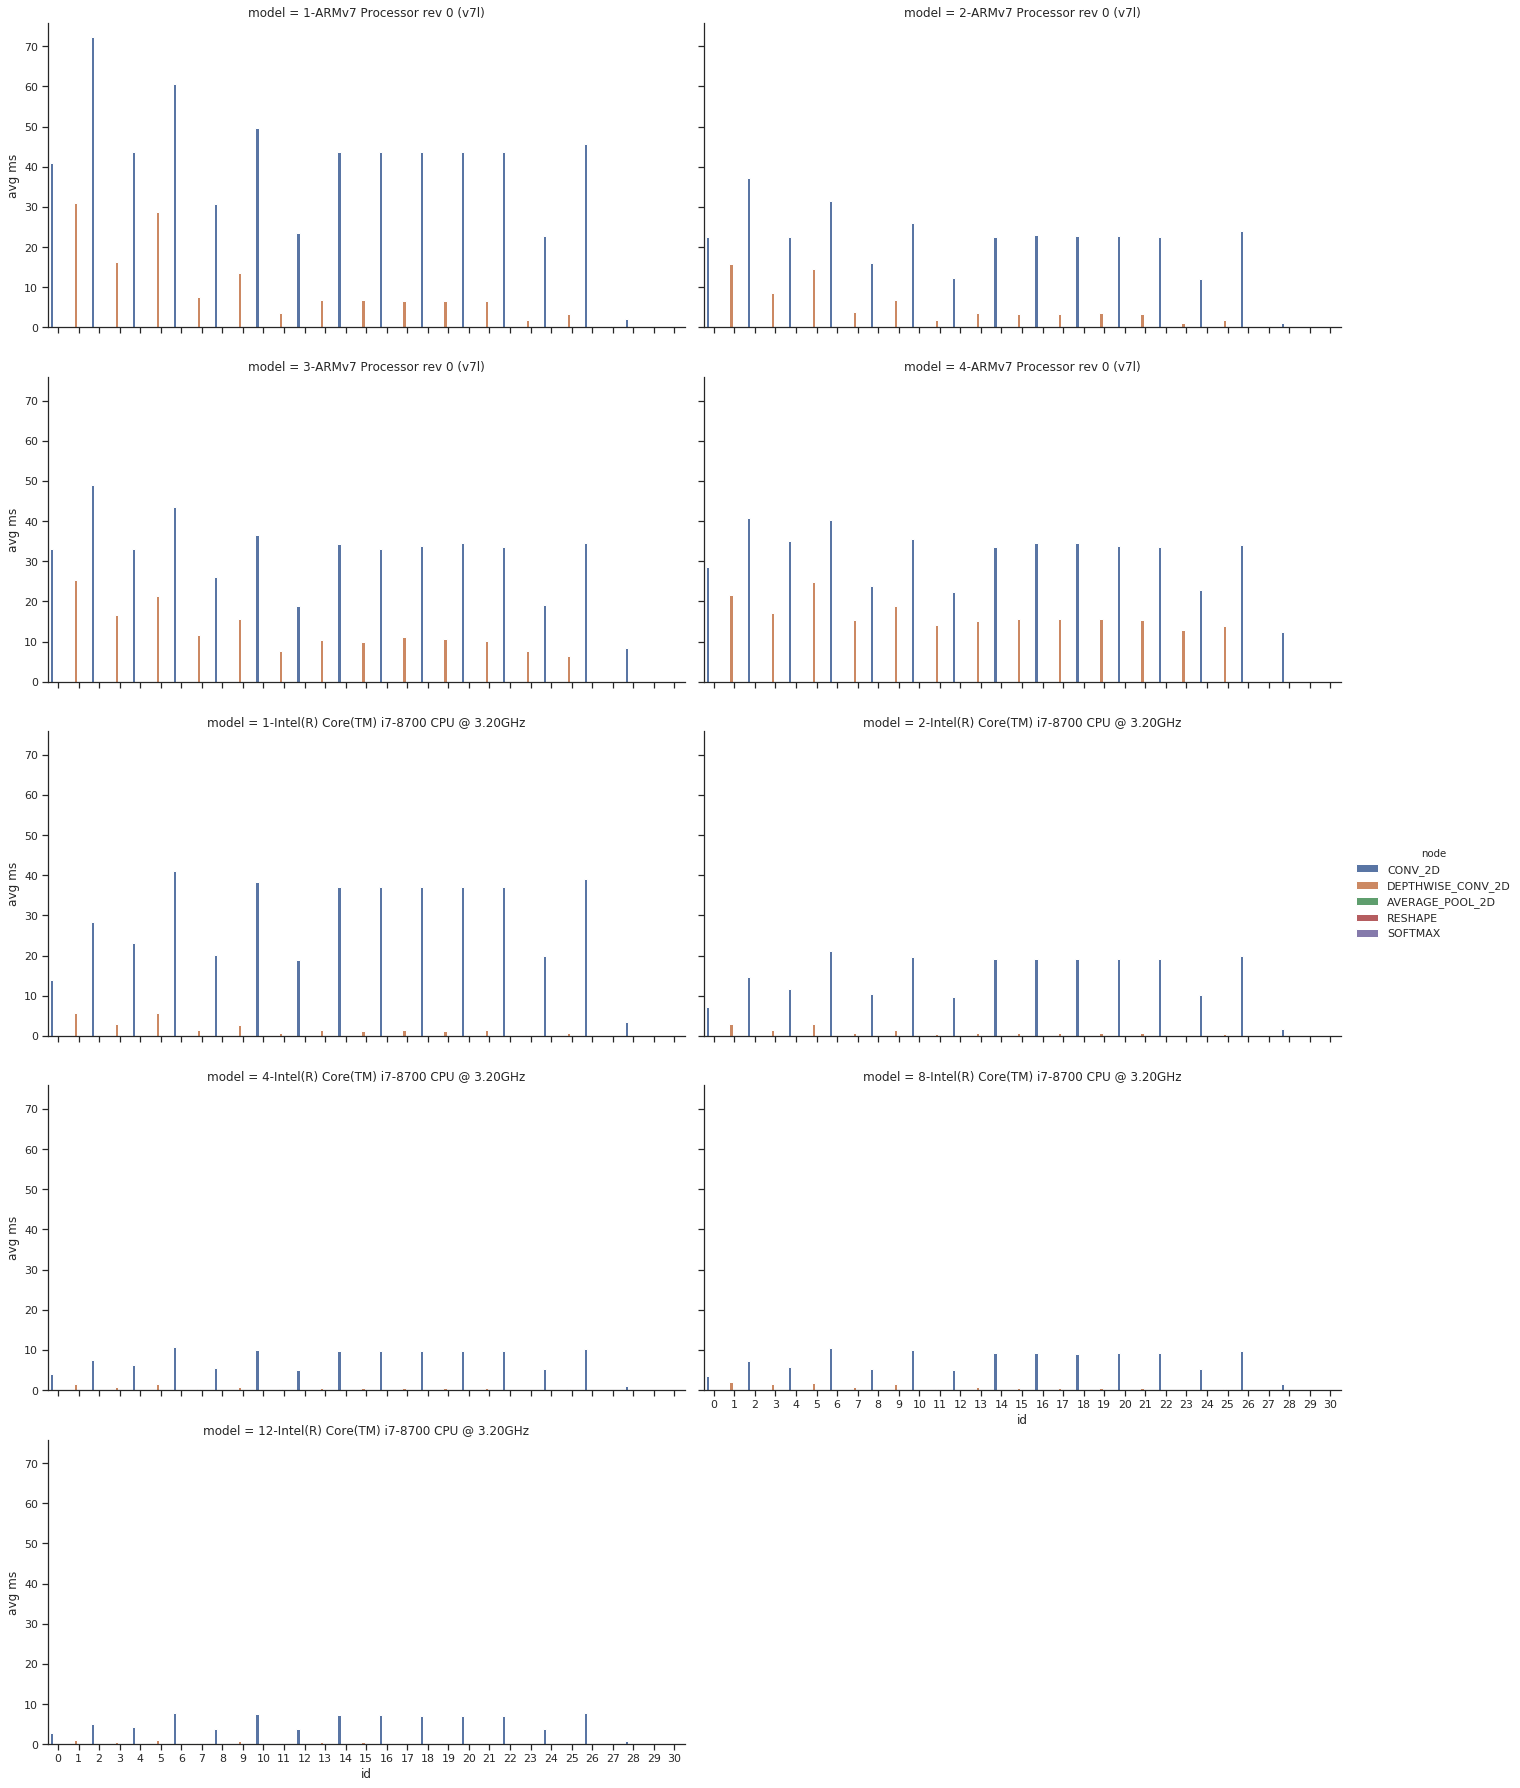

In [15]:
if __name__ == '__main__':                                                         
    '''main method for running the script'''                                       
    save = True   
    if (len(sys.argv) > 1):
        #boolean representing whether or not to save the graphs, defaults to true if not specified
        save = (sys.argv[1].lower() != 'false') 
                                                                              
    plotAll(files, save)  